In [2]:
# Bloque 1: Importaciones y Carga
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_excel('Obesity_Dataset.xlsx')

# Verificamos que cargó bien
print("dataset cargado")
print(f"Dimensiones del dataset: {df.shape}")

# --- LIMPIEZA ---
# Renombramos columnas para trabajar cómodo
df.columns = [
    'Sex', 'Age', 'Height', 'Family_History', 'Fast_Food',
    'Vegetables', 'Meals_Daily', 'Food_Between_Meals', 'Smoking',
    'Liquid_Intake', 'Calorie_Count', 'Physical_Excercise',
    'Tech_Time', 'Transportation', 'Class'
]

# One-Hot Encoding para Transporte (que no tiene orden)
df = pd.get_dummies(df, columns=['Transportation'], prefix='Transp')

# Ajustar binarios (1 y 2 -> 0 y 1)
binary_cols = ['Sex', 'Family_History', 'Fast_Food', 'Smoking', 'Calorie_Count']
for col in binary_cols:
    df[col] = df[col] - 1

# Ajustar Target (Clases 1-4 -> 0-3)
df['Class'] = df['Class'] - 1

print("Datos listos y limpios.")
df.head()


dataset cargado
Dimensiones del dataset: (1610, 15)
Datos listos y limpios.


,Sex,Age,Height,Family_History,Fast_Food,Vegetables,Meals_Daily,Food_Between_Meals,Smoking,Liquid_Intake,Calorie_Count,Physical_Excercise,Tech_Time,Class,Transp_1,Transp_2,Transp_3,Transp_4,Transp_5
0,1,18,155,1,1,3,1,3,1,1,1,3,3,1,False,False,False,True,False
1,1,18,158,1,1,3,1,1,1,1,1,1,3,1,False,False,True,False,False
2,1,18,159,1,1,2,1,3,1,3,1,2,3,1,False,False,False,True,False
3,1,18,162,1,1,2,2,2,1,2,1,1,3,1,False,False,False,True,False
4,1,18,165,1,0,2,1,3,1,1,1,3,3,1,False,True,False,False,False


In [3]:
# --- BLOQUE 2: División de Datos ---

# 1. Definir X (Features) y y (Target)
X = df.drop('Class', axis=1)
y = df['Class']

# 2. División 80/20
# stratify=y asegura que tengamos la misma proporción de obesos/delgados en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos divididos correctamente:")
print(f"train: {X_train.shape[0]} pacientes")
print(f"test: {X_test.shape[0]} pacientes")

Datos divididos correctamente:
train: 1288 pacientes
test: 322 pacientes


In [5]:
# --- BLOQUE 3: Modelo Base (Benchmark) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Crear el modelo
# n_estimators=100 es el estándar (100 árboles de decisión)
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Entrenar
print("Entrenando")
base_model.fit(X_train, y_train)

# 3. Prediccion
y_pred_base = base_model.predict(X_test)

# 4. Evaluar resultados
accuracy = accuracy_score(y_test, y_pred_base)
print(f"\n--- PRECISIÓN DEL MODELO BASE: {accuracy:.2%} ---\n")

# Definimos los nombres de las clases
class_names = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
print(classification_report(y_test, y_pred_base, target_names=class_names))

Entrenando

--- PRECISIÓN DEL MODELO BASE: 86.34% ---

              precision    recall  f1-score   support

   Bajo Peso       0.89      0.53      0.67        15
      Normal       0.88      0.93      0.91       132
   Sobrepeso       0.85      0.85      0.85       118
    Obesidad       0.84      0.82      0.83        57

    accuracy                           0.86       322
   macro avg       0.87      0.78      0.81       322
weighted avg       0.86      0.86      0.86       322



In [6]:
# Bloque 4: Imports y Definición del Pipeline
import mlflow
import mlflow.sklearn
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Definimos el flujo de trabajo (Pipeline)
# Nota en PCA: Si pones un float (ej. 0.90), Sklearn calcula los componentes necesarios para el 90%
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # 1. Estandarizar
    ('pca', PCA(n_components=0.90)),   # 2. Reducir dimensiones (manteniendo 90% info)
    ('nn', MLPClassifier(max_iter=500, random_state=42)) # 3. Red Neuronal
])

print("Pipeline definido: Estandarización -> PCA -> Red Neuronal")

Pipeline definido: Estandarización -> PCA -> Red Neuronal


In [7]:
# Bloque 5: Fine-Tuning y MLflow

# 1. Definir el "Espacio de Búsqueda" (Hyperparameters)
# Probaremos mantener el 85% o 90% de varianza en PCA
# Probaremos diferentes capas ocultas en la neurona (ej: (50,) es una capa de 50 neuronas)
param_grid = {
    'pca__n_components': [0.85, 0.90, 0.95], # Varianza explicada deseada
    'nn__hidden_layer_sizes': [(50,), (100,), (50, 50)], # Arquitecturas
    'nn__activation': ['relu', 'tanh'], # Funciones de activación
    'nn__alpha': [0.0001, 0.001, 0.01] # Regularización (L2 penalty)
}

# 2. Configurar MLflow
mlflow.set_experiment("Proyecto_Obesidad_PCA_NN")

print("Iniciando Fine-Tuning y registro en MLflow...")

with mlflow.start_run():
    # Usamos GridSearchCV para probar todas las combinaciones
    # cv=3 significa validación cruzada de 3 pliegues
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    
    # Entrenamos (Aquí ocurre la magia: Scaler -> PCA -> NN -> Optimización)
    grid_search.fit(X_train, y_train)
    
    # 3. Registrar los mejores resultados en MLflow
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Logueamos parámetros y métricas
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy_cv", best_score)
    
    # Logueamos el modelo completo (el pipeline)
    mlflow.sklearn.log_model(best_model, "modelo_obesidad_pca")
    
    print(f"\n--- MEJOR RESULTADO ---")
    print(f"Mejor Accuracy (Cross-Validation): {best_score:.2%}")
    print(f"Mejores Parámetros: {best_params}")
    
    # Análisis del PCA seleccionado
    pca_step = best_model.named_steps['pca']
    n_components = pca_step.n_components_
    print(f"Para explicar la varianza deseada, PCA redujo las 15 variables a: {n_components} componentes principales.")

C:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


Iniciando Fine-Tuning y registro en MLflow...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
2025/12/12 15:52:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/12 15:52:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- MEJOR RESULTADO ---
Mejor Accuracy (Cross-Validation): 76.55%
Mejores Parámetros: {'nn__activation': 'tanh', 'nn__alpha': 0.0001, 'nn__hidden_layer_sizes': (100,), 'pca__n_components': 0.95}
Para explicar la varianza deseada, PCA redujo las 15 variables a: 15 componentes principales.


In [8]:
# Bloque 6: Predicción de un Nuevo Ejemplo (Simulación)

# Tomamos un paciente del set de prueba (datos crudos, 15 variables)
nuevo_paciente = X_test.iloc[0:1] 

print("Datos del paciente original (15 variables):")
print(nuevo_paciente)

# Hacemos la predicción DIRECTA usando el pipeline optimizado
prediccion = best_model.predict(nuevo_paciente)

# Interpretación
clases = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
resultado = clases[prediccion[0]]

print(f"\n--- PREDICCIÓN ---")
print(f"El modelo (usando PCA interno) predice: {resultado}")

Datos del paciente original (15 variables):
     Sex  Age  Height  Family_History  Fast_Food  Vegetables  Meals_Daily  \
345    1   48     165               0          0           1            2   

     Food_Between_Meals  Smoking  Liquid_Intake  Calorie_Count  \
345                   1        0              3              0   

     Physical_Excercise  Tech_Time  Transp_1  Transp_2  Transp_3  Transp_4  \
345                   5          2      True     False     False     False   

     Transp_5  
345     False  

--- PREDICCIÓN ---
El modelo (usando PCA interno) predice: Sobrepeso



REPORTE DETALLADO DE MÉTRICAS
              precision    recall  f1-score   support

        Bajo       0.89      0.53      0.67        15
      Normal       0.85      0.88      0.87       132
   Sobrepeso       0.75      0.72      0.73       118
    Obesidad       0.70      0.77      0.73        57

    accuracy                           0.79       322
   macro avg       0.80      0.73      0.75       322
weighted avg       0.79      0.79      0.78       322



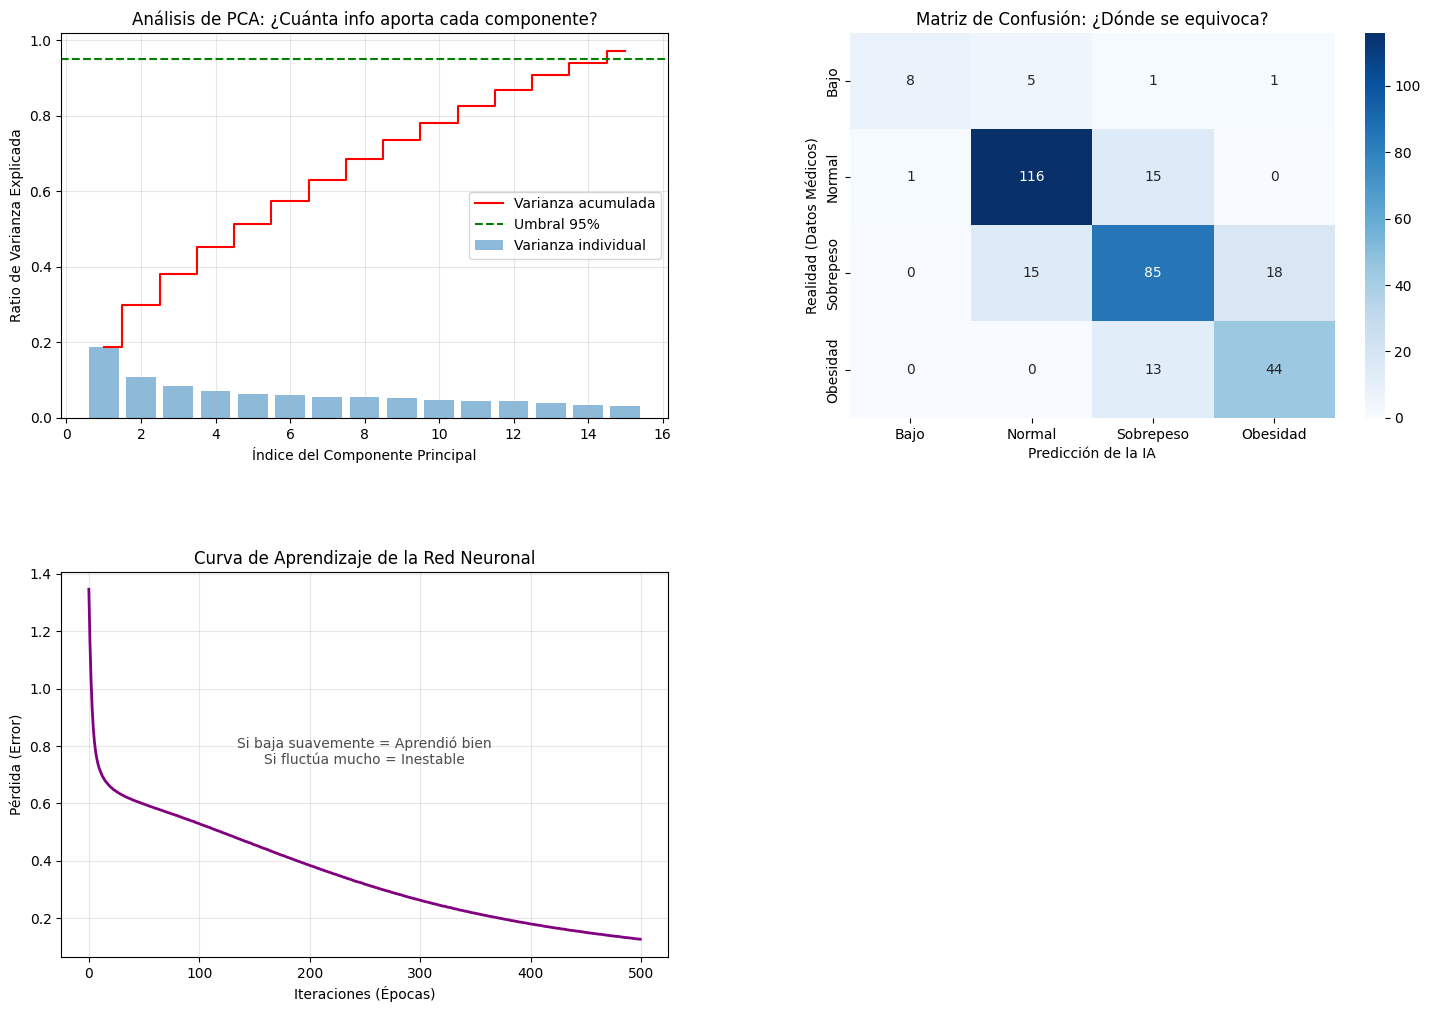

In [9]:
# Bloque 7: Dashboard de Diagnóstico Avanzado
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Recuperar los objetos entrenados del Pipeline
# best_model es el pipeline completo. Accedemos a los pasos por nombre.
pca_final = best_model.named_steps['pca']
nn_final = best_model.named_steps['nn']

# Configuración de estilo
plt.style.use('default') # Estilo limpio
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- GRÁFICO 1: Varianza Explicada Acumulada (Scree Plot) ---
ax1 = fig.add_subplot(2, 2, 1)
# Obtenemos la varianza explicada por cada componente
var_exp = pca_final.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
n_comps = len(var_exp)

ax1.bar(range(1, n_comps + 1), var_exp, alpha=0.5, align='center', label='Varianza individual')
ax1.step(range(1, n_comps + 1), cum_var_exp, where='mid', label='Varianza acumulada', color='red')
ax1.axhline(y=0.95, color='green', linestyle='--', label='Umbral 95%')
ax1.set_ylabel('Ratio de Varianza Explicada')
ax1.set_xlabel('Índice del Componente Principal')
ax1.set_title('Análisis de PCA: ¿Cuánta info aporta cada componente?')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: Matriz de Confusión (Mapa de Calor) ---
ax2 = fig.add_subplot(2, 2, 2)
y_pred_final = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)
# Normalizamos para ver porcentajes en lugar de números brutos (opcional, aquí números brutos)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            xticklabels=['Bajo', 'Normal', 'Sobrepeso', 'Obesidad'],
            yticklabels=['Bajo', 'Normal', 'Sobrepeso', 'Obesidad'])
ax2.set_title('Matriz de Confusión: ¿Dónde se equivoca?')
ax2.set_xlabel('Predicción de la IA')
ax2.set_ylabel('Realidad (Datos Médicos)')

# --- GRÁFICO 3: Curva de Aprendizaje (Loss Curve) ---
ax3 = fig.add_subplot(2, 2, 3)
# MLP guarda su historia de pérdida en loss_curve_
ax3.plot(nn_final.loss_curve_, color='purple', linewidth=2)
ax3.set_title('Curva de Aprendizaje de la Red Neuronal')
ax3.set_xlabel('Iteraciones (Épocas)')
ax3.set_ylabel('Pérdida (Error)')
ax3.grid(True, alpha=0.3)
ax3.text(0.5, 0.5, 'Si baja suavemente = Aprendió bien\nSi fluctúa mucho = Inestable', 
         transform=ax3.transAxes, ha='center', alpha=0.7)

# --- REPORTE DE TEXTO EN CONSOLA ---
print("\n" + "="*50)
print("REPORTE DETALLADO DE MÉTRICAS")
print("="*50)
print(classification_report(y_test, y_pred_final, target_names=['Bajo', 'Normal', 'Sobrepeso', 'Obesidad']))

plt.show()

Documentando 54 intentos diferentes en MLflow...
 -> Gráfico guardado: comparacion_modelos.png


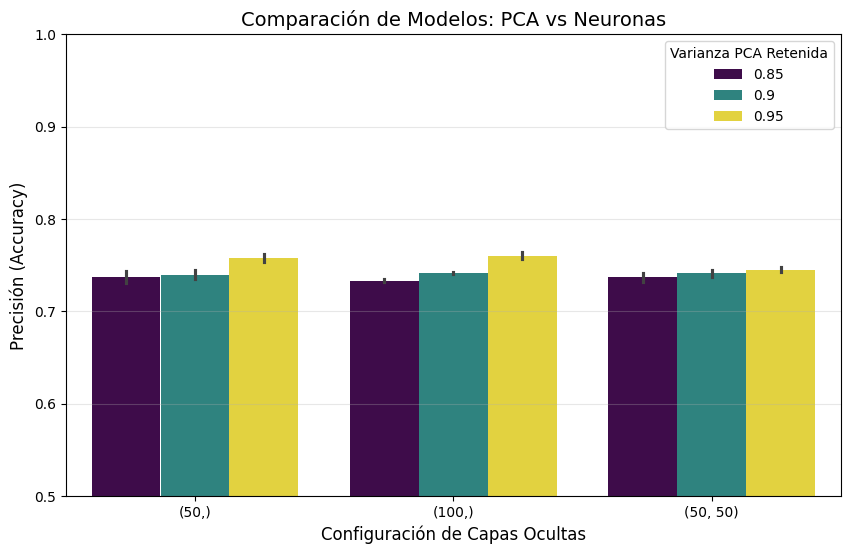

C:\Users\sebas\AppData\Local\Temp\ipykernel_36876\2965686999.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='PCA_Varianza', y='Accuracy', palette='coolwarm')


 -> Gráfico guardado: estabilidad_pca.png


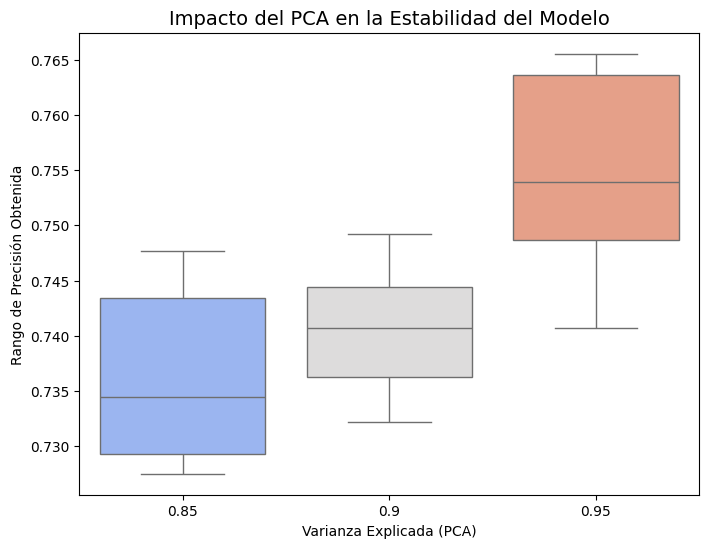

 -> Tabla de datos guardada: tabla_intentos_gridsearch.csv

¡Documentación completada en MLflow!
Revisa la pestaña de MLflow (o la carpeta local mlruns) para ver las evidencias.


In [10]:
# Bloque 8: Documentación Visual Avanzada en MLflow (Dashboard para el Profe)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# 1. Extraer los resultados de "todos los intentos" del GridSearch
# cv_results_ contiene la bitácora de cada prueba que hizo la IA
results_df = pd.DataFrame(grid_search.cv_results_)

# Filtramos solo las columnas que nos interesan para el gráfico
# (Parametros probados y su puntuación media)
cols_to_keep = ['param_pca__n_components', 'param_nn__hidden_layer_sizes', 'mean_test_score']
results_df = results_df[cols_to_keep]

# Renombramos para que se entienda mejor en el gráfico
results_df.columns = ['PCA_Varianza', 'Arquitectura_Neuronal', 'Accuracy']
# Convertimos la arquitectura a string para poder graficarla como categoría
results_df['Arquitectura_Neuronal'] = results_df['Arquitectura_Neuronal'].astype(str)

print(f"Documentando {len(results_df)} intentos diferentes en MLflow...")

# Iniciar un contexto de MLflow para registrar los gráficos
# Usamos el run_id del mejor modelo o iniciamos uno nuevo de "Reporte"
with mlflow.start_run(run_name="Graficos_Analisis_Resultados"):

    # --- GRÁFICO A: Rendimiento por Arquitectura (Barplot) ---
    plt.figure(figsize=(10, 6))
    # Graficamos: Eje X = Arquitectura, Eje Y = Precisión, Color = Nivel de PCA
    sns.barplot(data=results_df, x='Arquitectura_Neuronal', y='Accuracy', hue='PCA_Varianza', palette='viridis')
    
    plt.title('Comparación de Modelos: PCA vs Neuronas', fontsize=14)
    plt.ylabel('Precisión (Accuracy)', fontsize=12)
    plt.xlabel('Configuración de Capas Ocultas', fontsize=12)
    plt.ylim(0.5, 1.0) # Ajustamos el límite para ver mejor las diferencias
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Varianza PCA Retenida')
    
    # Guardar imagen y subirla a MLflow
    filename_a = "comparacion_modelos.png"
    plt.savefig(filename_a)
    mlflow.log_artifact(filename_a)
    print(f" -> Gráfico guardado: {filename_a}")
    plt.show()

    # --- GRÁFICO B: Distribución de Resultados (Boxplot) ---
    # Esto muestra la estabilidad del modelo estocástico
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=results_df, x='PCA_Varianza', y='Accuracy', palette='coolwarm')
    plt.title('Impacto del PCA en la Estabilidad del Modelo', fontsize=14)
    plt.ylabel('Rango de Precisión Obtenida')
    plt.xlabel('Varianza Explicada (PCA)')
    
    # Guardar imagen y subirla a MLflow
    filename_b = "estabilidad_pca.png"
    plt.savefig(filename_b)
    mlflow.log_artifact(filename_b)
    print(f" -> Gráfico guardado: {filename_b}")
    plt.show()

    # --- CSV DE RESULTADOS ---
    # También subimos el Excel con todos los intentos por si el profe quiere ver los números brutos
    results_df.to_csv("tabla_intentos_gridsearch.csv", index=False)
    mlflow.log_artifact("tabla_intentos_gridsearch.csv")
    print(" -> Tabla de datos guardada: tabla_intentos_gridsearch.csv")

print("\n¡Documentación completada en MLflow!")
print("Revisa la pestaña de MLflow (o la carpeta local mlruns) para ver las evidencias.")